# UniverSeg - Evaluation on Our Dataset

In [23]:
from IPython.display import display, Markdown, Latex
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from UniverSeg.universeg import universeg
import sys
import itertools
from liver_metastasis_dataset import LiverTumorsDataset
from liver_metastasis_dataset_3D import LiverTumorsDataset3D
from monai.inferers import SliceInferer
import math
import matplotlib.pyplot as plt
import einops as E
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from skimage.transform import resize
import pandas as pd
sys.path.append("/cs/casmip/alina.ryabtsev/Tools")
from CalculateMeasures import calculate_measures_dataframe

In [24]:
%reload_ext autoreload
%autoreload 2

In [4]:
sys.path.append('UniverSeg')

First we will load the model and the dataset.

In [5]:
model = universeg(pretrained=True)
_ = model.to(device)
print(f"Running on device: {device}")

Running on device: cuda


We create a split of support and query images from the liver tumors dataset. Let's initialize K to be 10.

In [4]:
d_support = LiverTumorsDataset(split="support", label=1)
d_query = LiverTumorsDataset(split="query", label=1)
K = 10  # number of shots in support

100%|██████████| 109/109 [01:39<00:00,  1.09it/s]


In [5]:
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

Now we will add some helper functions to visualize data and evaluate the model.

In [9]:
def visualize_tensors(tensors: torch.tensor, col_wrap: int=8, col_names: str=None, title: str=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

\begin{center}
$ Dice = \frac{2 * A \cap B}{A+B}$
\end{center}

In [84]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    intersection = torch.logical_and(y_true, y_pred)
    if y_pred.sum() + y_true.sum() == 0:
        return 1
    return float(format(2. * intersection.sum() / (y_true.sum() + y_pred.sum()), '.3f'))

In [7]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

Now we would like to visualize the samples of the support set

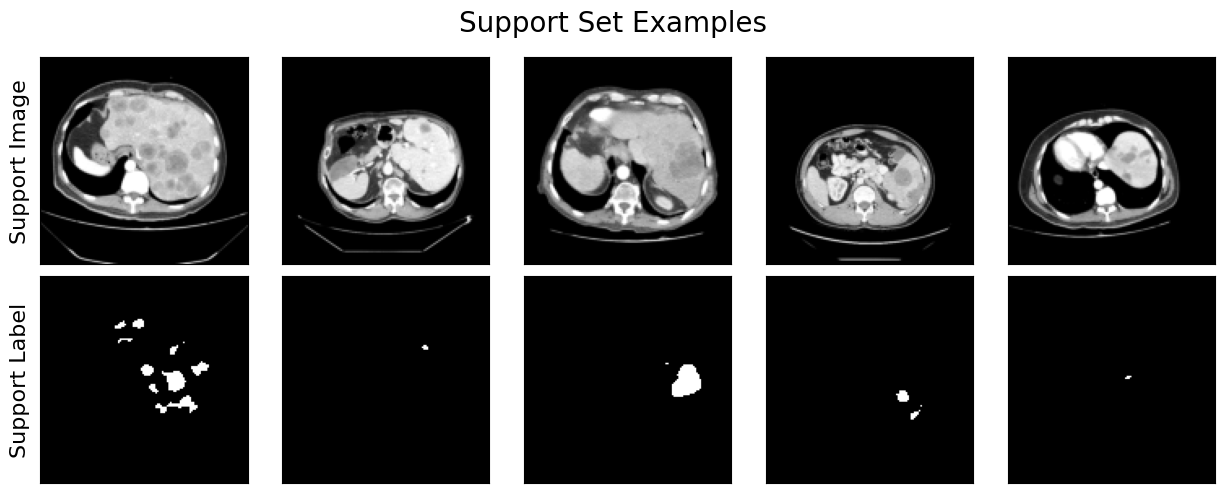

In [9]:
rng = range(95,100)
support_images, support_labels = [d_support[i][0] for i in rng], [d_support[i][1] for i in rng]
n_viz = 5
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=5, title='Support Set Examples')

Now we will run the inference model on the query images

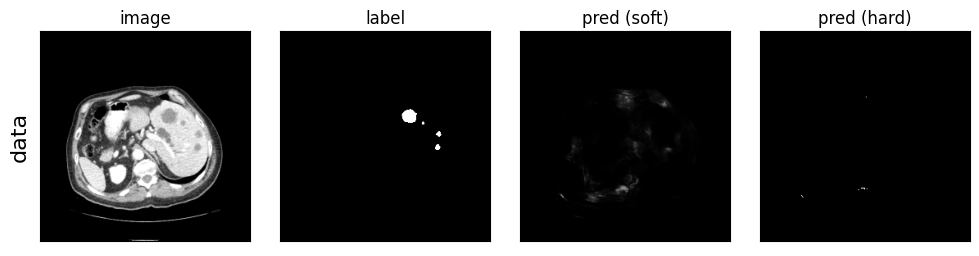

In [8]:
# select an image, label test pair
idx = np.random.permutation(len(d_query))[0]
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

Now we will try the same process as above with different K

In [8]:
K = 5
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

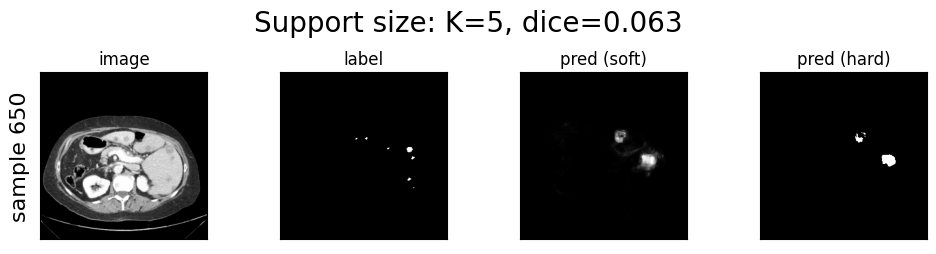

In [12]:
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

In [13]:
K = 10
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [ ]:
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

In [15]:
K = 16
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

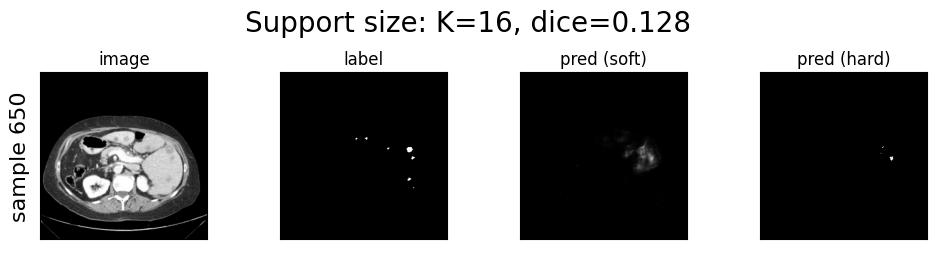

In [16]:
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

In [17]:
K = 20
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

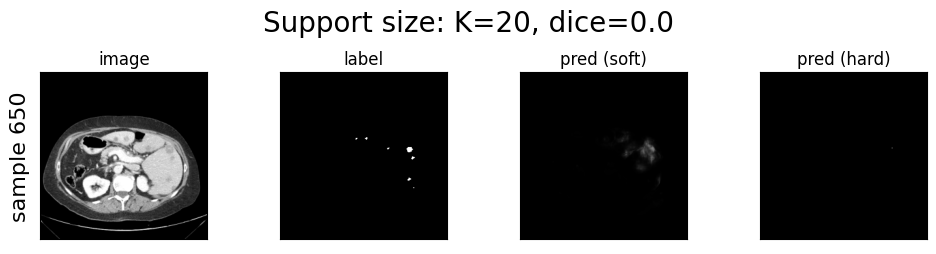

In [18]:
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

In [19]:
K = 48
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

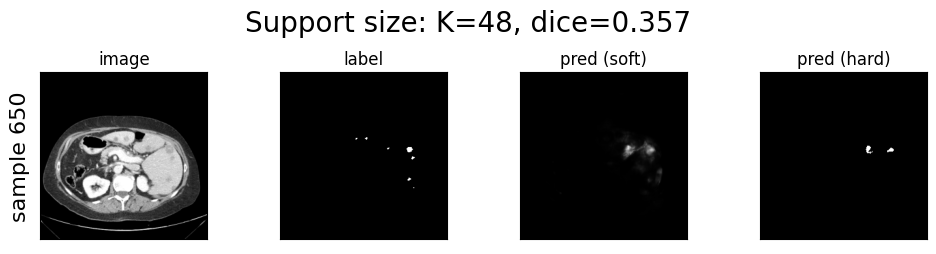

In [20]:
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

Now we would like to have only images with actual segmentations in the support set

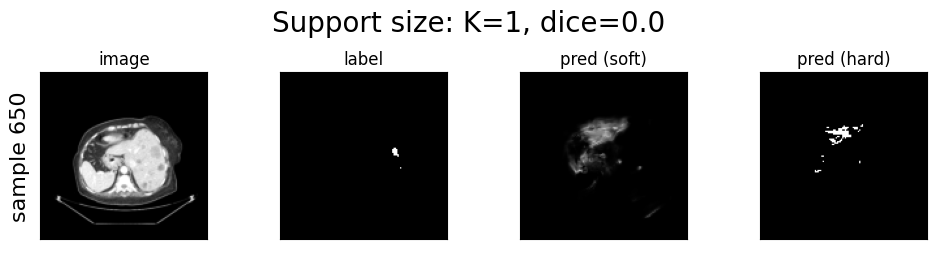

In [11]:
K = 1
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

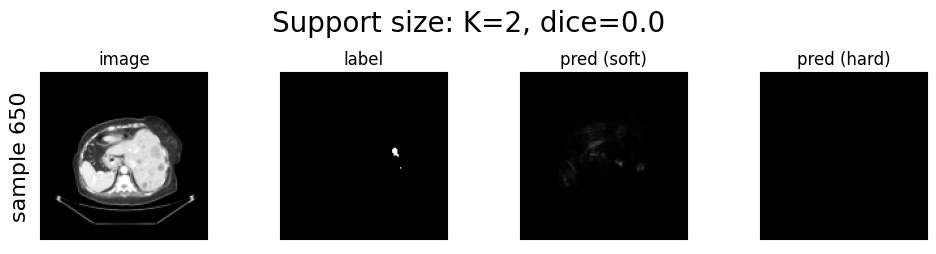

In [12]:
K = 2
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

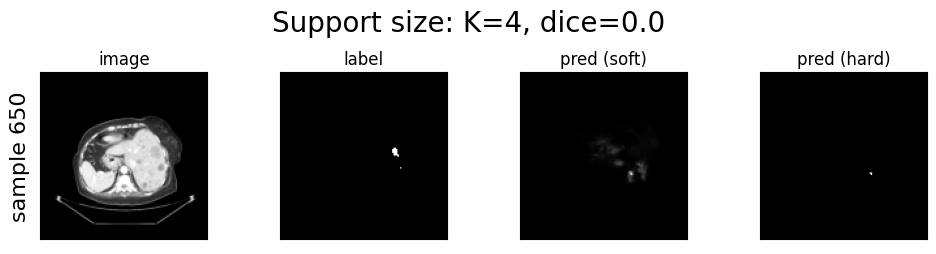

In [13]:
K = 4
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

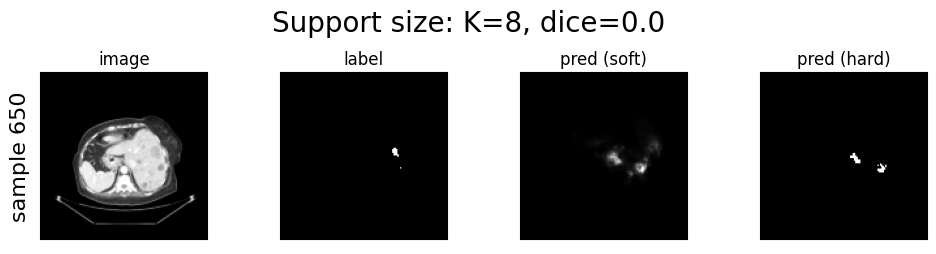

In [14]:
K = 8
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

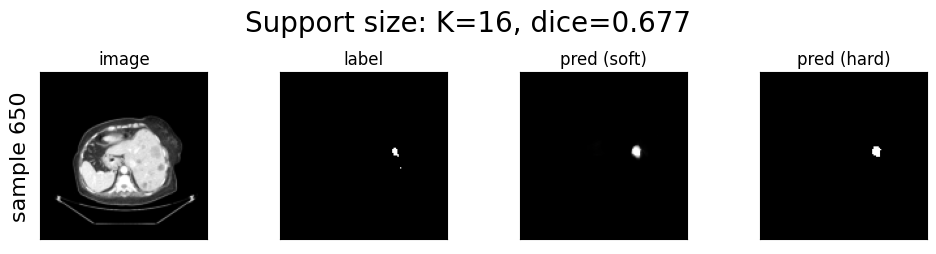

In [15]:
K = 16
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

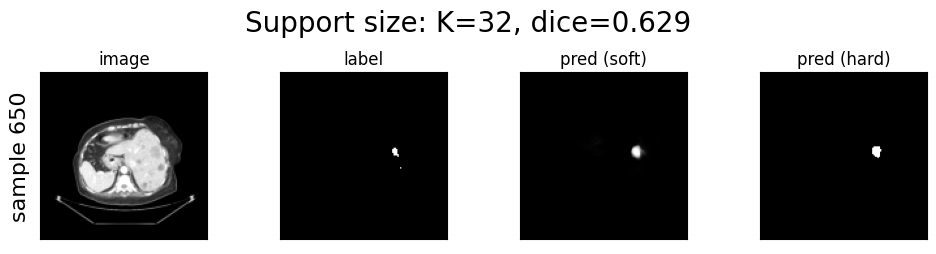

In [16]:
K = 32
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

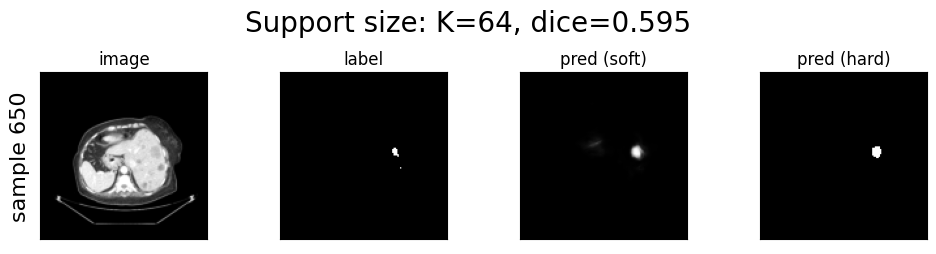

In [17]:
K = 64
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

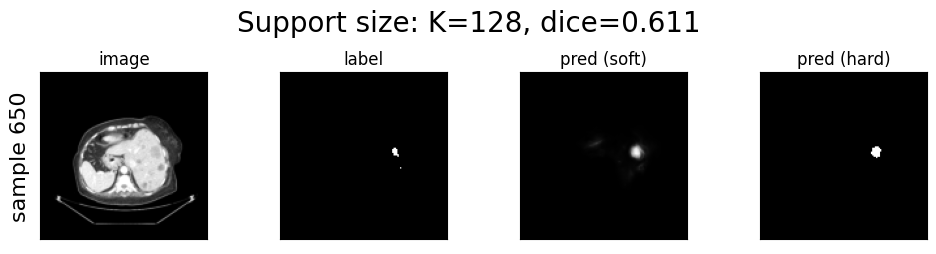

In [18]:
K = 128
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
# select an image, label test pair
# idx = np.random.permutation(len(d_query))[0]
idx = 650
image, label = d_query[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
pred = torch.sigmoid(logits)

# visualize
hard_pred = pred > 0.5
dice = np.round(dice_score(hard_pred, label), 3)
res = {f'sample {idx}': [image, label, pred, hard_pred]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

Now we would like to calculate some stats over all query images

In [5]:
K = 32
support_images, support_labels = zip(*itertools.islice(d_support, K))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

100%|██████████| 10/10 [00:00<00:00, 43.81it/s]


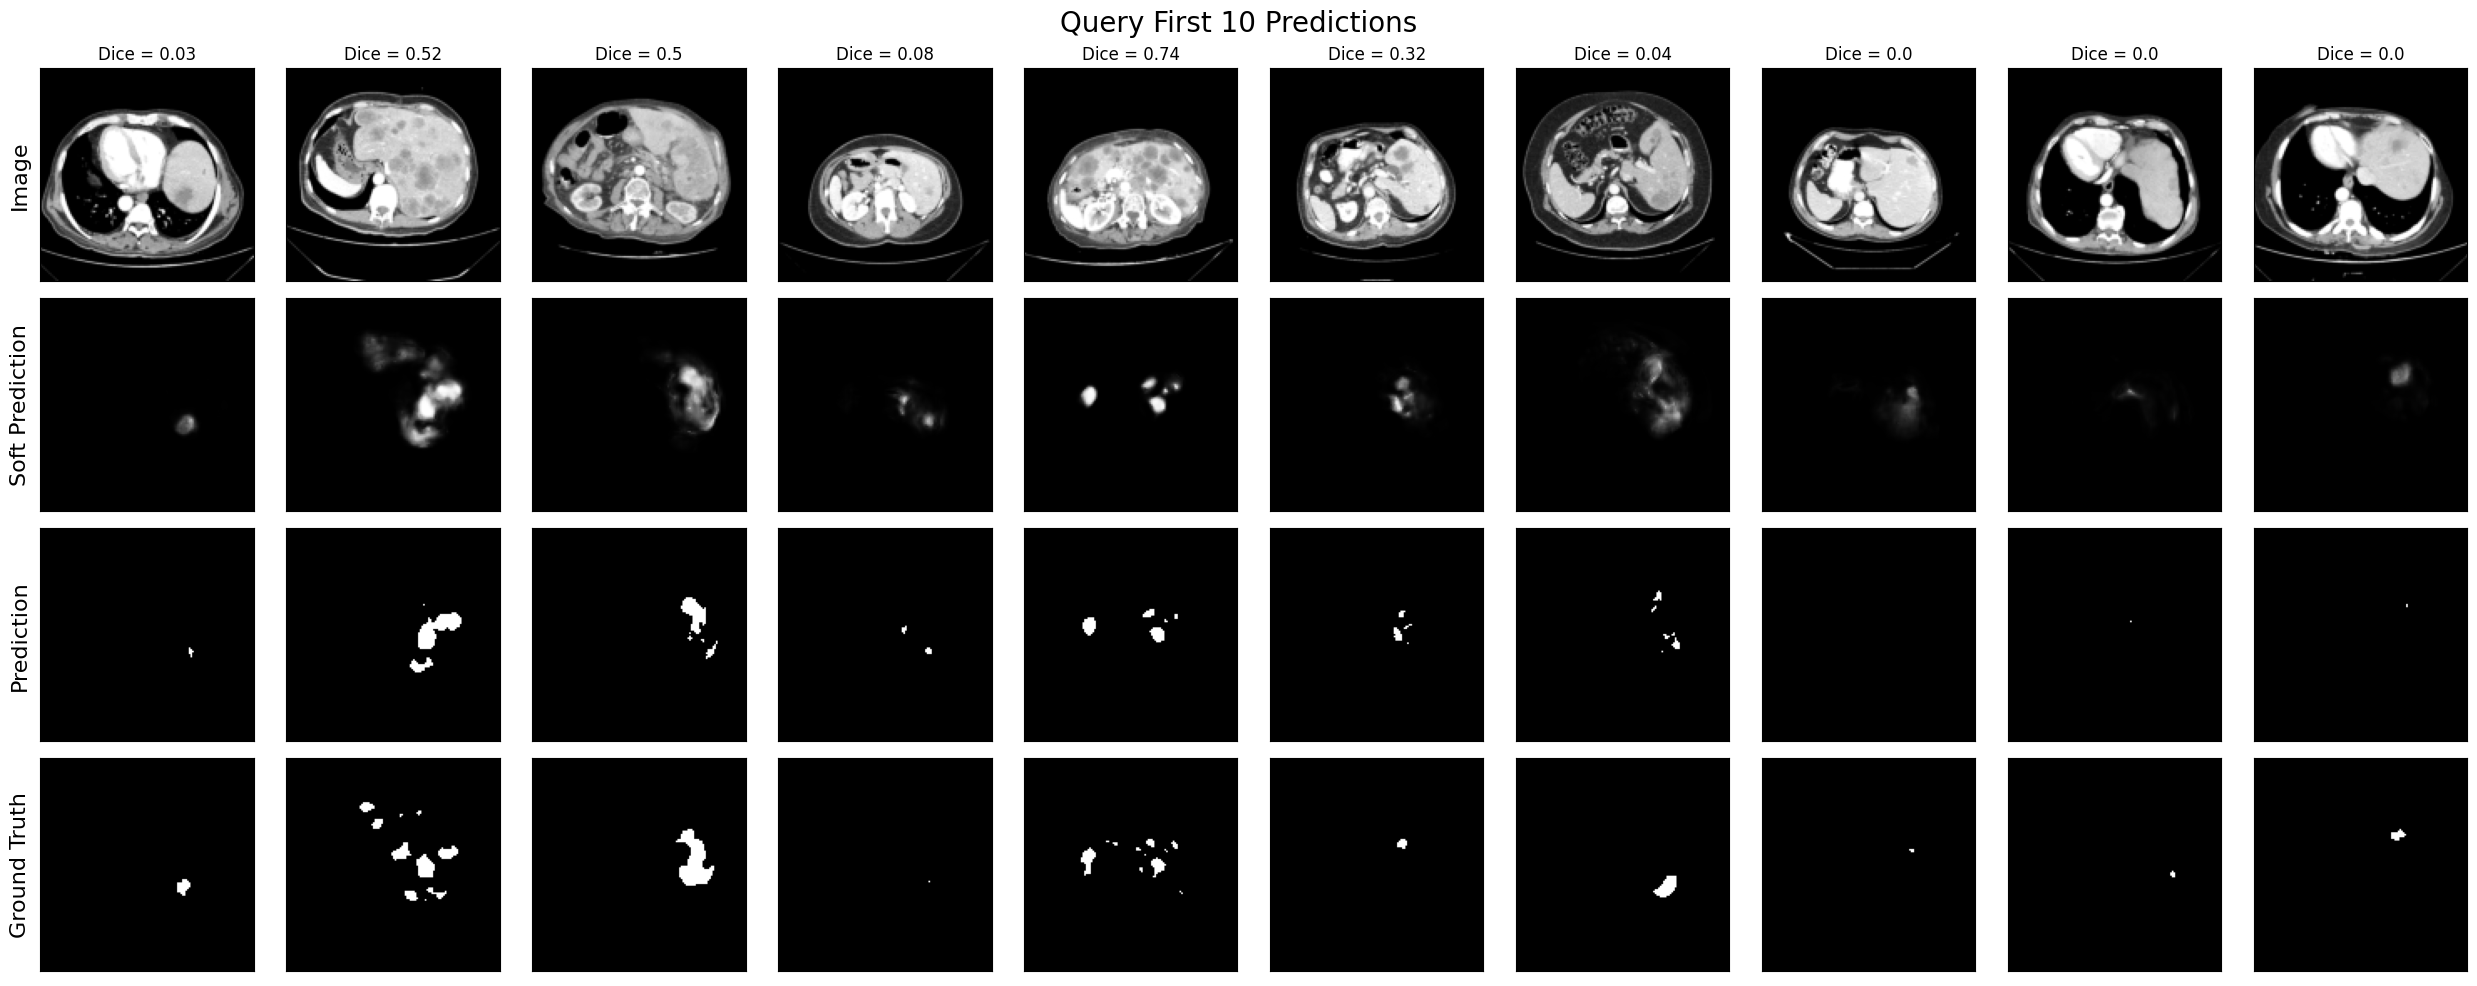

In [32]:
# plot 10 random query images
n_predictions = len(d_query)
results = defaultdict(list)

# compute inference and save predictions and Dice metrics for n_predictions.
idxs = np.random.permutation(n_predictions)[:10]

for i in tqdm(idxs):
    image, label = d_query[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
n_present = 10
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {np.round(s,2)}' for s in scores][:n_present],
                  title=f'Query First {n_present} Predictions',
                  col_wrap=n_present)

In [85]:
n_predictions = len(d_query)
results = defaultdict(list)

# compute inference and save predictions and Dice metrics for n_predictions.

for i in tqdm(range(n_predictions)):
    image, label = d_query[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
n_present = 10
scores = results.pop('score')
scores_series = pd.Series(scores)
scores_series.describe()

100%|██████████| 665/665 [00:12<00:00, 51.28it/s]


count    665.000000
mean       0.258812
std        0.282835
min        0.000000
25%        0.000000
50%        0.143000
75%        0.528000
max        0.893000
dtype: float64

### Conclusions so Far:
1. When having support and query slices with tumors, we get some reasonable signal, as even the third quarter of images obtain Dice score higher than 0.52. The support size is 32 although there are 1551 images in the support dataset overall. Every scan in overall has an average of 30-50 slices with 10 slices of tumors in average. Hence - using support set of only 32 slices is like using 3 scans in support, ot of 70+ scans that are in the split of the support set.
2. We should run precision and recall analysis.
3. Make the query dataset organized, containing negative samples (i.e., do not contain any tumors within slices). Transform back to 3D image?

Now we will calculate all measures (detection and segmentation) of the query images:

In [203]:
image_p = results["Image"][200]
label_p = results['Ground Truth'][200]
pred_p = results["Soft Prediction"][200]
hard_pred_p = results["Prediction"][200]
dice = scores[200]

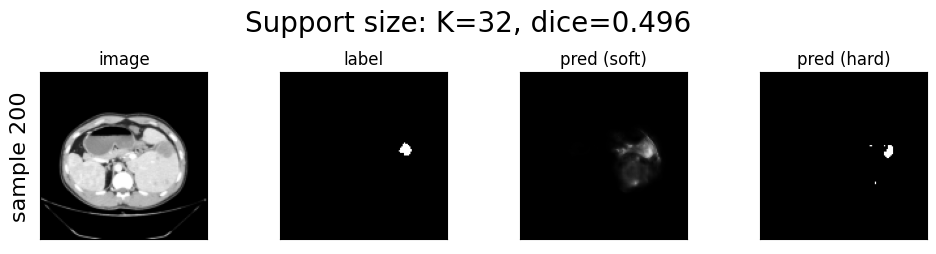

In [204]:
res_p = {f'sample {200}': [image_p, label_p, pred_p, hard_pred_p]}
titles = col_names = ['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res_p, col_wrap=4, title=f"Support size: K={K}, dice={dice}", col_names=titles)

In [205]:
plt.imsave("/cs/casmip/alina.ryabtsev/try.png", image_p.squeeze().cpu().detach().numpy(), cmap="gray")

In [215]:
predictions = [resize(r.cpu().detach().numpy(), (r.shape[0] * 4, r.shape[1] * 4, r.shape[2]), anti_aliasing=True) for r in results["Prediction"]]
gt = [resize(r.cpu().detach().numpy(), (r.shape[0] * 4, r.shape[1] * 4, r.shape[2]), anti_aliasing=True) for r in results["Ground Truth"]]

In [216]:
results_detection = calculate_measures_dataframe("tumors", predictions, gt, range(1, 2), pix_dim=True)[1]

Calculating measures for threshold 1
Setting pixel dimensions to (1,1,1)


100%|██████████| 665/665 [00:09<00:00, 68.00it/s] 


Calculating measures for threshold 1 finished


#### Final Results (detection and segmentation)

In [217]:
results_detection[0].drop("Filename", inplace=True, axis=1)
results_detection[0]  # all lesions

,Num of lesion,Dice,Dice with FN,Segmentation TP (cc),Segmentation FP (cc),Segmentation FN (cc),Total tumor volume GT (cc),Total tumor volume Predictions (cc),Delta between total tumor volumes (cc),Delta between total tumor volumes (%),...,Tumor Burden Delta (%),Detection TP (per lesion),Detection FP (per lesion),Detection FN (per lesion),Precision,Recall,F1 Score,Mean ASSD (mm),Mean Hausdorff (mm),Max Hausdorff (mm)
mean,1.972932,0.724666,0.280567,0.704842,0.461570,1.070364,1.775206,1.166412,0.608794,24.647672,...,0.232782,0.787970,0.542857,1.184962,0.723400,0.439543,0.425874,2.957363,17.670207,20.975293
std,1.826641,0.294509,0.300864,1.550556,0.737834,1.794370,2.722975,2.013611,1.904013,60.260567,...,0.727706,0.932273,0.866919,1.388556,0.400074,0.437771,0.404850,4.001089,19.040237,24.563655
min,1.000000,0.008000,0.000000,0.000000,0.000000,0.000000,0.032000,0.000000,-6.112000,-98.963731,...,-2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132000,1.000000,1.000000
max,14.000000,1.000000,0.890000,9.680000,6.112000,11.728000,12.960000,11.312000,11.728000,100.000000,...,4.500000,7.000000,6.000000,9.000000,1.000000,1.000000,1.000000,29.678000,134.225000,176.343000
sum,1312.000000,481.903000,186.577000,468.720000,306.944000,711.792000,1180.512000,775.664000,404.848000,16390.701896,...,154.800000,524.000000,361.000000,788.000000,481.061000,292.296000,283.206000,1141.542000,6820.700000,8096.463000


In [218]:
results_detection[1].drop("Filename", inplace=True, axis=1)
results_detection[1]  # lesions greater than 5 mm

,Num of lesion,Dice,Dice with FN,Segmentation TP (cc),Segmentation FP (cc),Segmentation FN (cc),Total tumor volume GT (cc),Total tumor volume Predictions (cc),Delta between total tumor volumes (cc),Delta between total tumor volumes (%),...,Tumor Burden Delta (%),Detection TP (per lesion),Detection FP (per lesion),Detection FN (per lesion),Precision,Recall,F1 Score,Mean ASSD (mm),Mean Hausdorff (mm),Max Hausdorff (mm)
mean,1.542857,0.763451,0.415895,0.702003,0.453414,1.055326,1.757329,1.155777,0.601552,19.889617,...,0.228571,0.697744,0.372932,0.845113,0.764183,0.566026,0.494606,2.755269,17.447618,20.579238
std,1.541117,0.274401,0.372166,1.550184,0.735404,1.790789,2.718831,2.013583,1.903926,62.715175,...,0.728773,0.883455,0.648809,1.130789,0.392601,0.449101,0.435700,3.607314,18.145851,23.424614
min,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.144000,-100.000000,...,-2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132000,1.000000,1.000000
max,11.000000,1.000000,1.000000,9.680000,6.112000,11.696000,12.960000,11.312000,11.696000,100.000000,...,4.500000,5.000000,5.000000,7.000000,1.000000,1.000000,1.000000,26.256000,113.166000,160.112000
sum,1026.000000,507.695000,276.570000,466.832000,301.520000,701.792000,1168.624000,768.592000,400.032000,13226.594991,...,152.000000,464.000000,248.000000,562.000000,508.182000,376.407000,328.913000,972.610000,6159.009000,7264.471000


In [219]:
results_detection[2].drop("Filename", inplace=True, axis=1)
results_detection[2]  # lesions greater than 10 mm

,Num of lesion,Dice,Dice with FN,Segmentation TP (cc),Segmentation FP (cc),Segmentation FN (cc),Total tumor volume GT (cc),Total tumor volume Predictions (cc),Delta between total tumor volumes (cc),Delta between total tumor volumes (%),...,Tumor Burden Delta (%),Detection TP (per lesion),Detection FP (per lesion),Detection FN (per lesion),Precision,Recall,F1 Score,Mean ASSD (mm),Mean Hausdorff (mm),Max Hausdorff (mm)
mean,0.636090,0.850746,0.73097,0.651068,0.356932,0.897107,1.548174,1.008361,0.539814,8.360011,...,0.207970,0.416541,0.103759,0.219549,0.914662,0.853789,0.790045,3.398283,22.640713,25.744839
std,0.908406,0.246683,0.36073,1.551312,0.723287,1.752733,2.691112,2.015393,1.878725,55.680841,...,0.717769,0.695963,0.324317,0.499918,0.268937,0.328398,0.382048,4.140183,20.395474,25.129096
min,0.000000,0.008000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.144000,-100.000000,...,-2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132000,3.000000,3.000000
max,7.000000,1.000000,1.00000,9.680000,6.112000,11.392000,12.960000,11.312000,11.392000,100.000000,...,4.300000,5.000000,2.000000,3.000000,1.000000,1.000000,1.000000,26.256000,104.480000,113.137000
sum,423.000000,565.746000,486.09500,432.960000,237.360000,596.576000,1029.536000,670.560000,358.976000,5559.407362,...,138.300000,277.000000,69.000000,146.000000,608.250000,567.770000,525.380000,781.605000,5207.364000,5921.313000


#### Summary:

In [236]:
display(Markdown("#### All lesions:"))
results_detection[0][["Num of lesion", "Dice", "Mean ASSD (mm)", "Mean Hausdorff (mm)", "Precision", "Recall", "F1 Score"]]

#### All lesions:

,Num of lesion,Dice,Mean ASSD (mm),Mean Hausdorff (mm),Precision,Recall,F1 Score
mean,1.972932,0.724666,2.957363,17.670207,0.723400,0.439543,0.425874
std,1.826641,0.294509,4.001089,19.040237,0.400074,0.437771,0.404850
min,1.000000,0.008000,0.132000,1.000000,0.000000,0.000000,0.000000
max,14.000000,1.000000,29.678000,134.225000,1.000000,1.000000,1.000000
sum,1312.000000,481.903000,1141.542000,6820.700000,481.061000,292.296000,283.206000


In [237]:
display(Markdown("#### Greater than 5mm"))
results_detection[1][["Num of lesion", "Dice", "Mean ASSD (mm)", "Mean Hausdorff (mm)", "Precision", "Recall", "F1 Score"]]

#### Greater than 5mm

,Num of lesion,Dice,Mean ASSD (mm),Mean Hausdorff (mm),Precision,Recall,F1 Score
mean,1.542857,0.763451,2.755269,17.447618,0.764183,0.566026,0.494606
std,1.541117,0.274401,3.607314,18.145851,0.392601,0.449101,0.435700
min,0.000000,0.008000,0.132000,1.000000,0.000000,0.000000,0.000000
max,11.000000,1.000000,26.256000,113.166000,1.000000,1.000000,1.000000
sum,1026.000000,507.695000,972.610000,6159.009000,508.182000,376.407000,328.913000


In [238]:
display(Markdown("#### Greater than 10mm"))
results_detection[2][["Num of lesion", "Dice", "Mean ASSD (mm)", "Mean Hausdorff (mm)", "Precision", "Recall", "F1 Score"]]

#### Greater than 10mm

,Num of lesion,Dice,Mean ASSD (mm),Mean Hausdorff (mm),Precision,Recall,F1 Score
mean,0.636090,0.850746,3.398283,22.640713,0.914662,0.853789,0.790045
std,0.908406,0.246683,4.140183,20.395474,0.268937,0.328398,0.382048
min,0.000000,0.008000,0.132000,3.000000,0.000000,0.000000,0.000000
max,7.000000,1.000000,26.256000,104.480000,1.000000,1.000000,1.000000
sum,423.000000,565.746000,781.605000,5207.364000,608.250000,567.770000,525.380000


## What's Next?

1. Increase query set to 0.9 of the dataset.
2. Add non-including-lesions slices to query set.
3. Reconstruct 3D image from 2D slices.

### 3D Reconstruction

Now we will use SliceInference to reconstruct 3D images from 2D slices.

In [25]:
d1_support = LiverTumorsDataset3D(split="support", label=1)
d1_query = LiverTumorsDataset3D(split="query", label=1)

100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


In [12]:
K = 5  # number of shots in support

In [26]:
support_images, support_labels, support_filenames = zip(*itertools.islice(d1_support, K))
support_images = [img.to(device) for img in support_images]
support_labels = [img.to(device) for img in support_labels]

In [8]:
def model_wrapper(model, targets):
    """
    This function wraps the UniverSeg model to be used with Monai's slice inferer.
    :param model: universeg model
    :param targets: the target image to input slice inferer, and the support images and labels in 3D
    :type targets: a list of tensors
    :return:
    :rtype:
    """
    target_image, support_3d_images, support_3d_labels = targets
    logits = model(
        target_image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    return soft_pred, hard_pred

In [18]:
# How to do inference with slice inferer? Does the inferer gets 3D support images? How to provide image input+support/query images? Maybe with model wrapper?

@torch.no_grad()
def inference_with_slice_inferer(inferer, model_inferer, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference with Monai's slice inference
    soft_pred, hard_pred = inferer([image, support_images, support_labels], model_inferer)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'score': score}

In [19]:
inferer = SliceInferer(spatial_dim=0, roi_size=(128, 128))
total = len(d1_query)
results = []
with tqdm(total=total) as pbar:
    for pack in d1_query:
        image, label, filename = pack
        image, label = image.to(device), label.to(device)
        # inference with Monai's slice inference
        res = inference_with_slice_inferer(inferer, model, image, label, support_images, support_labels)
        res["Filename"] = filename
        results.append(res)
        pbar.update(1)

  0%|          | 0/32 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'shape'

In [20]:
image.shape

torch.Size([61, 128, 128])

In [27]:
support_labels[0].shape

torch.Size([42, 128, 128])